In [120]:
import pandas as pd
from datetime import datetime, timedelta
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate, find_peaks

In [121]:
# -----------------------------------------------------------------------------------
#                            1) Smooth the data 
# -----------------------------------------------------------------------------------
def smooth_data(csv, item_country, window_size=2):
    
    # a) Load the data
    df = pd.read_csv(csv, skiprows=1)  
    
    # b) Convert 'Week' column to datetime
    df['Week'] = pd.to_datetime(df['Week'])  

    # c) Apply a moving average to smooth the data ---> larger the window size, the smoother the data will be, but it may lose finer details
    df['Smoothed Interest'] = df[item_country].rolling(window=window_size, min_periods=1).mean()

    return df


In [122]:
# -----------------------------------------------------------------------------------
#                        3) Function to find moving average 
# -----------------------------------------------------------------------------------
def moving_average(signal, window_size):
    """
    Smooths the signal using a moving average filter.
    :param signal: The input signal (array-like).
    :param window_size: The size of the moving window.
    :return: Smoothed signal.
    """
    # Create an array of the window size with each element being 1/window_size
    window = np.ones(int(window_size))/float(window_size)

    # Use NumPy's convolve function to apply the moving average filter
    return np.convolve(signal, window, 'same')


# -----------------------------------------------------------------------------------
#                         4) Find delay from mvoing average
# -----------------------------------------------------------------------------------
def find_delay(a, b):
    x = moving_average(a,1)
    y = moving_average(b,1)
    
    if np.max(x) > np.min(x):
        x = (x - np.min(x)) / (np.max(x) - np.min(x))
        
    if np.max(y) > np.min(y):
        y = (y - np.min(y)) / (np.max(y) - np.min(y))

    # Compute cross-correlation
    corr = correlate(x, y, mode='full')

    # Find the index of the peak in the cross-correlation
    peak_idx = np.argmax(corr)

    # Compute the delay
    delay = peak_idx - (len(x) - 1)
    return delay

# -----------------------------------------------------------------------------------
#                         5) Create delay matrix for countries
# -----------------------------------------------------------------------------------
def create_delay_matrix(input_list):
    """
    Creates an n x n matrix of delays.
    :param input_list: A list of floats.
    :return: A numpy matrix of size n x n, where each entry is the result of find_delay(a, b).
    """
    n = len(input_list)
    delay_matrix = np.zeros((n, n))  # Initialize an n x n matrix

    for i in range(n):
        for j in range(n):
            delay_matrix[i, j] = find_delay(input_list[i], input_list[j])

    return delay_matrix

In [123]:
# -----------------------------------------------------------------------------------
#                            2) CREATE ARRAYS (for moving average) AND FILTER ONLY FOR FIRST CYCLE (to get relevant dealy
# -----------------------------------------------------------------------------------



df = pd.read_csv('fashion_master_list.csv')
df = df[['Country', 'Fashion Brand', 'Week','Interest']]
countries = df['Country'].to_numpy()
countries = np.unique(countries).tolist()
brands = df['Fashion Brand'].to_numpy()
brands = np.unique(brands).tolist()
#item = df[(df['Fashion Brand']=='Adidas') & (df['Country']=='Australia')]

items = []
for b in brands:
    item = []
    for c in countries:
        item.append(df[(df['Fashion Brand']==b) & (df['Country']==c)])
    items.append(item)
    

delay_matrices = []
for brand in items: 
    brand_list = []
    for country in brand:
        smoothed_item = smooth_data(country)
        country_interest_array = smoothed_item['Smoothed Interest'].to_numpy()[30:-200]
        brand_list.append(country_interest_array)
    
    matrix = create_delay_matrix(brand_list)
    delay_matrices.append(matrix)

In [124]:
len(delay_matrices)

25

In [125]:
delay_matrices = [dm for dm in delay_matrices if -29. not in dm and dm.max() > 0]

In [126]:
delay_matrices

[array([[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.,  0.],
        [ 0., -1., -1.,  0., -1.],
        [ 0.,  0.,  0.,  1.,  0.]]),
 array([[ 0.,  0., -1.,  0.,  0.],
        [ 0.,  0., -2.,  0.,  0.],
        [ 1.,  2.,  0.,  1.,  1.],
        [ 0.,  0., -1.,  0.,  0.],
        [ 0.,  0., -1.,  0.,  0.]]),
 array([[ 0., -1., -4.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.],
        [ 4.,  0.,  0.,  0.,  4.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -4.,  0.,  0.]]),
 array([[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.],
        [ 0.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]]),
 array([[  0., -18., -19., -18., -17.],
        [ 18.,   0.,  -1.,   0.,   0.],
        [ 19.,   1.,   0.,   2.,   2.],
        [ 18.,   0.,  -2.,   0.,   0.],
        [ 17.,   0.,  -2.,   0.,   0.]]),
 array([[  0.,  -2.,   0.,   0.,  24.],
        [  2.,   0.,   0.,   0.,   7.],
        [ 

In [127]:
# AVERAGE MATRIX
stacked_matrices = np.stack(delay_matrices, axis=0)
    # Compute the mean along the new dimension
mean_matrix = np.mean(stacked_matrices, axis=0)
print('AVERAGE DELAY MATRIX')
print(np.unique(countries).tolist())
print(mean_matrix)

AVERAGE DELAY MATRIX
['Australia', 'France', 'Italy', 'United Kingdom', 'United States']
[[ 0.         -3.45454545 -4.27272727 -3.09090909 -0.90909091]
 [ 3.45454545  0.         -0.72727273  0.18181818  0.36363636]
 [ 4.27272727  0.72727273  0.          1.          2.81818182]
 [ 3.09090909 -0.18181818 -1.          0.          2.09090909]
 [ 0.90909091 -0.36363636 -2.81818182 -2.09090909  0.        ]]


In [128]:
australia = sum([-3.45454545, -4.27272727, -3.09090909, -0.90909091]) / 4
france = sum([3.45454545, -0.72727273, 0.18181818, 0.36363636]) / 4
italy = sum([4.27272727, 0.72727273, 1., 2.81818182]) / 4
UK = sum([3.09090909, -0.18181818, -1., 2.09090909]) / 4
USA = sum([0.90909091, -0.36363636, -2.81818182, -2.09090909]) / 4

Delay France -> Australia = 3.45

Delay Australia -> France = -3.45

/tmp/ipykernel_1562/329485251.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


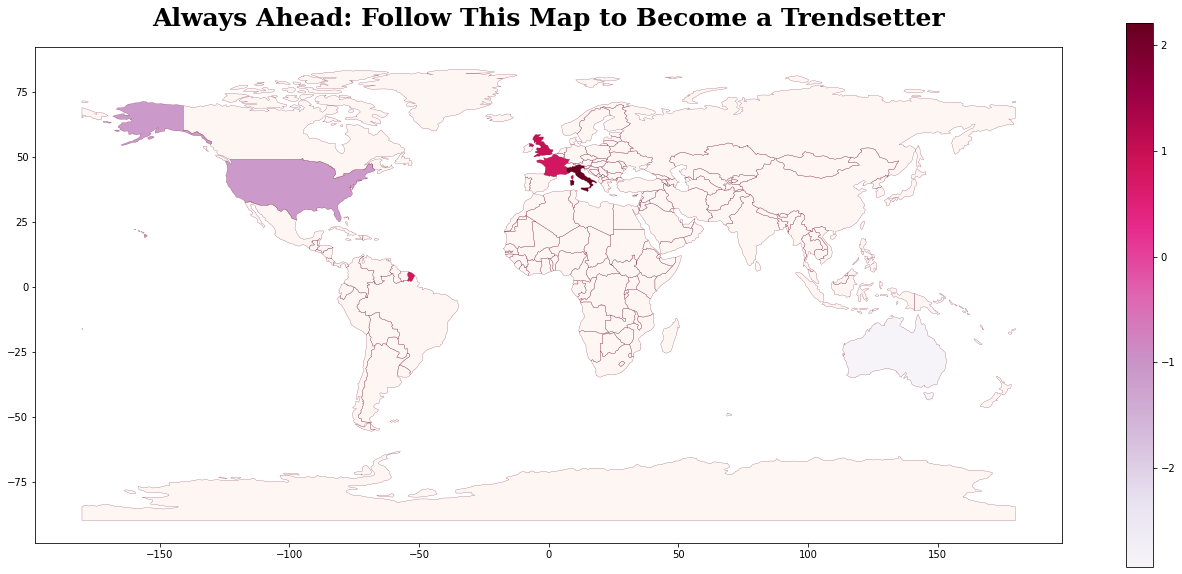

In [130]:
# -----------------------------------------------------------------------------------
#                         6) Add heat map
# -----------------------------------------------------------------------------------
import geopandas as gpd
# Load world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Assuming you have a dictionary like {'CountryName': average_delay, ...}
delays = {'Australia': australia, 'France': france, 'Italy': italy, 'United Kingdom': UK, 'United States of America': USA}

# Add a delay column to the world dataframe
world['delay'] = world['name'].map(delays)

# Filter out a specific country (e.g., 'Italy') from the map
country_to_exclude = 'Antartica'
world_filtered = world[world['name'] != country_to_exclude]

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(23,10))

world.plot(column='delay', ax=ax, legend=True, cmap='PuRd', missing_kwds={'color': '#FEF6F2'})
world.boundary.plot(ax=ax, linewidth=0.2, color='#6B0122')


title_font = {'fontsize': 25, 'fontweight': 'bold', 'fontfamily': 'serif'} 
plt.title('Always Ahead: Follow This Map to Become a Trendsetter', fontdict=title_font, y=1.03)
plt.show()